In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import copy
import numpy as np
from pathlib import Path
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import time
from datetime import datetime

# Add the project root to the path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.utils import extract_trailing_numbers, set_seed
import flowmol

In [3]:
from torch import Tensor
import torch.nn.functional as F
import dgl

In [4]:
from rdkit import RDLogger
# Hide everything RDKit logs (info/warnings/errors)
for name in ('rdApp.info', 'rdApp.warning', 'rdApp.error'):
    RDLogger.DisableLog(name)

In [5]:
def sampling(config: OmegaConf, model: flowmol.FlowMol, device: torch.device):
    new_molecules = model.sample_random_sizes(
        n_molecules = config.num_samples, 
        n_timesteps = config.num_integration_steps + 1, 
        device = device,
    )
    return new_molecules

In [6]:
def setup_gen_model(flow_model: str, device: torch.device):
    # Load - Flow Model
    gen_model = flowmol.load_pretrained(flow_model)
    gen_model.to(device)
    return gen_model

In [7]:
import argparse

def parse_args():
    parser = argparse.ArgumentParser(description="Run ALM with optional parameter overrides")
    # Settings
    parser.add_argument("--config", type=str, default="../configs/adjoint_matching.yaml",
                        help="Path to config file")
    parser.add_argument("--save_model", action='store_true',
                        help="Save the model, default: false")
    parser.add_argument("--save_samples", action='store_true',
                        help="Create animation of the samples and save the samples, default: false")
    parser.add_argument("--save_plots", action='store_true',
                        help="Save plots of rewards and constraints, default: false")
    parser.add_argument("--plotting_freq", type=int,
                        help="Plotting frequency")
    # FlowMol arguments
    flowmol_choices = ['geom_ctmc', 'geom_gaussian']
    parser.add_argument('--flow_model', type=str, choices=flowmol_choices,
                        help='pretrained model to be used')
    # Adjoint Matching Parameters
    parser.add_argument("--reward_lambda", type=float,
                        help="Override reward_lambda in config")
    parser.add_argument("--lr", type=float,
                        help="Override adjoint_matching.lr in config")
    parser.add_argument("--clip_grad_norm",  type=float,
                        help="Override adjoint_matching.clip_grad_norm in config")
    parser.add_argument("--batch_size", type=int,
                        help="Override adjoint_matching.batch_size in config")
    parser.add_argument("--samples_per_update", type=int,
                        help="Override adjoint_matching.num_samples in config")
    parser.add_argument("--num_integration_steps", type=int,
                        help="Override adjoint_matching.num_integration_steps in config")
    parser.add_argument("--finetune_steps", type=int,
                        help="Override adjoint_matching.finetune_steps in config")
    parser.add_argument("--num_iterations", type=int,
                        help="Override number of iterations")
    return parser.parse_args()

sys.argv = [""]

In [8]:
def update_config_with_args(config, args):
    # FlowMol arguments
    if args.flow_model is not None:
        config.flowmol.model = args.flow_model
    # Adjoint Matching Parameters
    if args.reward_lambda is not None:
        config.reward_lambda = args.reward_lambda
    if args.lr is not None:
        config.adjoint_matching.lr = args.lr
    if args.clip_grad_norm is not None:
        config.adjoint_matching.clip_grad_norm = args.clip_grad_norm
    if args.batch_size is not None:
        config.adjoint_matching.batch_size = args.batch_size
    if args.samples_per_update is not None:
        config.adjoint_matching.sampling.num_samples = args.samples_per_update
    if args.num_integration_steps is not None:
        config.adjoint_matching.sampling.num_integration_steps = args.num_integration_steps
    if args.finetune_steps is not None:
        config.adjoint_matching.finetune_steps = args.finetune_steps
    if args.num_iterations is not None:
        config.adjoint_matching.num_iterations = args.num_iterations
    return config

In [9]:
import random 

rand_int = random.randint(0, 1e4)
print(rand_int)

4604


In [10]:
# Parse command line arguments
args = parse_args()

# Load config from file
config_path = Path(args.config)
config = OmegaConf.load(config_path)

# Update config with command line arguments
config = update_config_with_args(config, args)

# Setup - Seed and device and root directory
set_seed(rand_int)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
root_dir = Path(config.root) / Path(config.experiment)

# Settings
if args.plotting_freq is None:
    args.plotting_freq = max(config.adjoint_matching.num_iterations // 20, 1)

# General Parameters
flowmol_model = config.flow_model

# Adjoint Matching Parameters
reward_lambda = config.reward_lambda
learning_rate = config.adjoint_matching.lr
clip_grad_norm = config.adjoint_matching.clip_grad_norm
traj_samples_per_stage = config.adjoint_matching.sampling.num_samples
traj_len = config.adjoint_matching.sampling.num_integration_steps
finetune_steps = config.adjoint_matching.finetune_steps
num_iterations = config.adjoint_matching.num_iterations

config.adjoint_matching.sampling.sampler_type = "memoryless"
config.reward_sampling.sampler_type = "euler"

In [11]:
device

device(type='cpu')

In [12]:
print(OmegaConf.to_yaml(config))

seed: 42
verbose: false
root: /Users/svlg/MasterThesis/v02/
experiment: am_dipole_test
flow_model: geom_gaussian
reward:
  fn: dipole
reward_lambda: 100
adjoint_matching:
  num_iterations: 150
  batch_size: 6
  clip_grad_norm: 0.5
  clip_loss: 100000.0
  lr: 0.0001
  finetune_steps: 4
  sampling:
    sampler_type: memoryless
    num_samples: 24
    num_integration_steps: 40
reward_sampling:
  sampler_type: euler
  num_samples: 30
  num_integration_steps: 100



In [13]:
# Setup - Gen Model
gen_model = setup_gen_model(config.flow_model, device=device)

In [14]:
gen_model.parameterization

'endpoint'

In [15]:
config.reward_sampling.num_samples = 5

In [16]:
config.reward_sampling

{'sampler_type': 'euler', 'num_samples': 5, 'num_integration_steps': 100}

## Sampling

In [17]:
# Generate Samples
new_molecules = sampling(
    config.reward_sampling,
    copy.deepcopy(gen_model),
    device=device
)

/opt/homebrew/Caskroom/miniforge/base/envs/deep/lib/python3.9/site-packages/dgl/backend/pytorch/tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In [18]:
new_molecules

In [19]:
remove_node_keys = ['x_0', 'a_0', 'c_0', 'x_1_pred', 'a_1_pred', 'c_1_pred', 'x_1', 'a_1', 'c_1']
remove_edge_keys = ['e_0', 'e_1_pred', 'e_1']

In [20]:
rdkit_molecules = []
for mol in new_molecules:
    rdkit_molecules.append(mol.rdkit_mol)
    for tmp in remove_node_keys:
        mol.g.ndata.pop(tmp, None)
    for tmp in remove_edge_keys:
        mol.g.edata.pop(tmp, None)

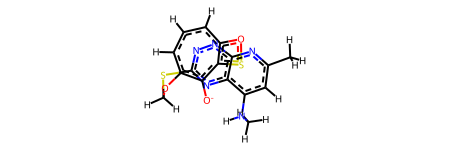

In [21]:
mol0 = new_molecules[0]
mol0.rdkit_mol

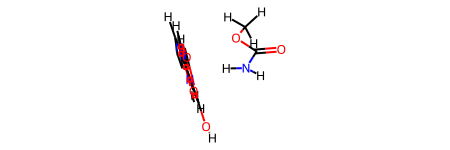

In [22]:
mol1 = new_molecules[1]
mol1.rdkit_mol

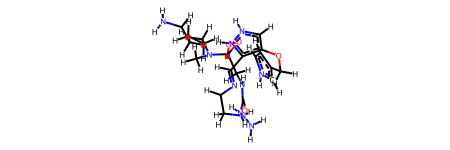

In [23]:
mol2 = new_molecules[2]
mol2.rdkit_mol

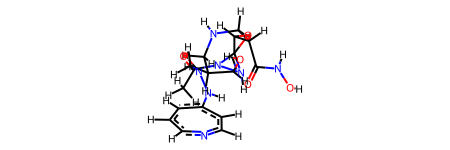

In [24]:
mol3 = new_molecules[3]
mol3.rdkit_mol

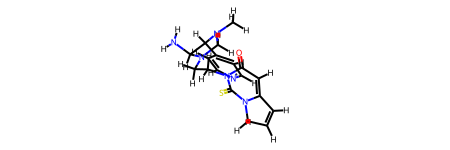

In [25]:
mol4 = new_molecules[4]
mol4.rdkit_mol

#### Shape checking

In [26]:
mol_graph = mol0.g

In [27]:
g = mol0.g

In [28]:
mol_graph.edata["e_t"].shape

torch.Size([1482, 5])

In [29]:
h = torch.cat([
    g.ndata["a_t"],
    g.ndata["c_t"],
    g.ndata["x_t"],
], dim=-1)
h.shape

torch.Size([39, 19])

## Propertiy Prediction

In [30]:
class GNN(nn.Module):
    def __init__(self, node_feats: int, edge_feats: int, hidden_dim=256, depth=6):
        super().__init__()

        self.in_conv = dgl.nn.GraphConv(node_feats, hidden_dim)
        self.edge_linear = nn.Linear(edge_feats, hidden_dim)

        blocks = []
        for _ in range(depth):
            blocks.append(ResBlock(hidden_dim, hidden_dim))
        self.blocks = nn.ModuleList(blocks)

        self.head = nn.Linear(hidden_dim, 1)

        nn.init.zeros_(self.head.weight)
        nn.init.zeros_(self.head.bias)

    def forward(self, g: dgl.DGLGraph) -> Tensor:
        with g.local_scope():
            h = torch.cat([
                g.ndata["a_t"],
                g.ndata["c_t"],
                g.ndata["x_t"],
            ], dim=-1)
            h = self.in_conv(g, h)

            # Add edge feature to initial representation
            g.edata["e"] = self.edge_linear(g.edata["e_t"])

            g.update_all(
                dgl.function.copy_e("e", "m"),    # message: copy each edge's "e" to mailbox "m"
                dgl.function.mean("m", "e_mean")  # reduce: mean over mailbox → store in ndata['e_mean']
            )
            h += g.ndata["e_mean"]

            for block in self.blocks:
                h = block(g, h)

            g.ndata["h"] = h
            h = dgl.readout_nodes(g, "h", op="mean")
            return self.head(h)


class ResBlock(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = dgl.nn.GraphConv(in_dim, out_dim)
        self.norm1 = nn.LayerNorm(out_dim)

        self.conv2 = dgl.nn.GraphConv(out_dim, out_dim)
        self.norm2 = nn.LayerNorm(out_dim)

        self.skip = nn.Linear(in_dim, out_dim) if in_dim != out_dim else nn.Identity()

    def forward(self, g: dgl.DGLGraph, x: Tensor) -> Tensor:
        h = self.conv1(g, x)
        h = self.norm1(h)
        h = F.silu(h)

        h = self.conv2(g, h)
        h = self.norm2(h)
        h = F.silu(h)

        return h + self.skip(x)

In [31]:
model = GNN(node_feats=19, edge_feats=5).to(device)

In [32]:
model(g)

tensor([[0.]], grad_fn=<AddmmBackward0>)

## RDKIT validity checker

In [33]:
from rdkit.Chem import rdmolops

def is_connected(mol):
    """
    Returns (True/False, fragments).
    fragments is a tuple of tuples of atom indices (one per fragment).
    """
    frags = rdmolops.GetMolFrags(mol, asMols=False, sanitizeFrags=False)
    return len(frags) == 1, len(frags)

In [34]:
print(is_connected(mol0.rdkit_mol))
print(is_connected(mol1.rdkit_mol))
print(is_connected(mol2.rdkit_mol))
print(is_connected(mol3.rdkit_mol))
print(is_connected(mol4.rdkit_mol))

(True, 1)
(False, 2)
(False, 2)
(True, 1)
(True, 1)


In [35]:
from rdkit import Chem

def valence_ok(mol):
    """
    Returns (True/False, problems).
    Uses RDKit's sanitization + problem detector to surface valence issues.
    """
    m = Chem.Mol(mol)  # work on a copy
    problems = []
    try:
        # strict=True makes impossible valences raise immediately
        m.UpdatePropertyCache(strict=True)
        # Full sanitization (includes valence checks, aromaticity, etc.)
        Chem.SanitizeMol(m)
        return True, problems
    except Exception as e:
        # If sanitization fails, gather detailed problems
        try:
            # DetectChemistryProblems pinpoints offending atoms/bonds
            probs = rdmolops.DetectChemistryProblems(m)
            for p in probs:
                where = []
                if p.GetAtom() is not None:
                    where.append(f"atom {p.GetAtom().GetIdx()} ({p.GetAtom().GetSymbol()})")
                if p.GetBond() is not None:
                    b = p.GetBond()
                    where.append(f"bond {b.GetIdx()} ({b.GetBeginAtomIdx()}–{b.GetEndAtomIdx()})")
                problems.append(f"{p.GetType()}: {'; '.join(where) if where else 'location n/a'}")
        except Exception:
            # Fallback if detector isn’t available in your RDKit build
            problems.append(str(e))
        return False, problems

In [36]:
counter = 0
for mol in [mol0, mol1, mol2, mol3, mol4]:
    print(f"Checking molecule {counter}")
    ok, issues = valence_ok(mol.rdkit_mol)
    print("Valence/sanitization OK:", ok)
    if not ok:
        print("Issues detected:")
    for line in issues:
        print("  -", line)
    counter += 1

Checking molecule 0
Valence/sanitization OK: False
Issues detected:
Checking molecule 1
Valence/sanitization OK: False
Issues detected:
  - non-ring atom 9 marked aromatic
Checking molecule 2
Valence/sanitization OK: False
Issues detected:
  - Explicit valence for atom # 33 C, 5, is greater than permitted
Checking molecule 3
Valence/sanitization OK: False
Issues detected:
  - Explicit valence for atom # 10 C, 5, is greater than permitted
Checking molecule 4
Valence/sanitization OK: True


In [37]:
import py3Dmol

for tmp_mol in [mol0, mol1, mol2, mol3, mol4]:
    try:
        pdb_block = Chem.MolToMolBlock(tmp_mol.rdkit_mol)
    except:
        continue
    # Visualize using py3Dmol
    viewer = py3Dmol.view(width=250, height=250)
    viewer.addModel(pdb_block, "mol")
    viewer.setStyle({"stick": {}, "sphere": {"scale": 0.3}})
    viewer.zoomTo()
    viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [38]:
import re

def _parse_kekulized_atom_count_from_exception(exc_msg: str):
    """
    Extract 'Unkekulized atoms: 7 8 22 ...' -> count, else None.
    """
    if not exc_msg:
        return None
    m = re.search(r"Unkekulized atoms:\s*([0-9\s]+)", exc_msg)
    if not m:
        return None
    return len(re.findall(r"\d+", m.group(1)))

def _infer_problem_type(obj, fallback_other="other"):
    """
    Try to classify a problem object/exception into {'valence','kekul','other'}.
    Works with RDKit problem objects and C++ exception proxies.
    """
    # 1) RDKit problem objects often have GetType()
    try:
        t = (obj.GetType() or "").lower()
    except Exception:
        t = ""
    # 2) Use class name / string as a fallback
    cls = obj.__class__.__name__.lower()
    s   = ""
    try:
        s = str(obj).lower()
    except Exception:
        pass

    text = " ".join([t, cls, s])
    if "valence" in text:
        return "valence"
    if "kekul" in text or "kekulé" in text or "kekulize" in text:
        return "kekul"
    return fallback_other

def score_molecule(mol):
    """
    Returns (score in [0,1], reasons list).

    Policy:
      - If disconnected (fragments > 1): 1.0 immediately.
      - Else try strict cache + full sanitization.
      - If sanitization fails, bucket problems by severity:
          * Valence: base 0.75 + 0.25 * (affected/total)
          * Kekulization: base 0.70 + 0.30 * (affected/total)
          * Other: base 0.60 + 0.40 * (affected/total)
        Combine multiple penalties via: 1 - Π(1 - p_i), then cap at 1.0.
    """
    reasons = []
    n_atoms = mol.GetNumAtoms() or 1  # keep nonzero

    # 1) Connectivity (your hard rule)
    frags = rdmolops.GetMolFrags(mol, asMols=False, sanitizeFrags=False)
    if len(frags) > 1:
        reasons.append(f"Disconnected: {len(frags)} fragments")
        return 1.0, reasons

    # 2) Sanitization
    m = Chem.Mol(mol)  # copy
    exc_msg = None
    problems = []
    try:
        m.UpdatePropertyCache(strict=True)
        Chem.SanitizeMol(m)
        return 0.0, reasons  # perfect
    except Exception as e:
        exc_msg = str(e)
        try:
            problems = rdmolops.DetectChemistryProblems(m) or []
        except Exception:
            problems = []

    # 3) Collect counts per class, without assuming attributes exist
    buckets = {
        "valence": {"count_atoms": 0, "count_items": 0},
        "kekul":   {"count_atoms": 0, "count_items": 0},
        "other":   {"count_atoms": 0, "count_items": 0},
    }

    for p in problems:
        kind = _infer_problem_type(p)
        if kind not in buckets:
            kind = "other"
        buckets[kind]["count_items"] += 1
        # Only increment atom count if GetAtom exists and returns something
        try:
            if hasattr(p, "GetAtom"):
                a = p.GetAtom()
                if a is not None:
                    buckets[kind]["count_atoms"] += 1
        except Exception:
            pass

    # Special augmentation: kekulization count from exception text
    if (buckets["kekul"]["count_items"] == 0) and exc_msg and ("kekul" in exc_msg.lower()):
        k = _parse_kekulized_atom_count_from_exception(exc_msg)
        buckets["kekul"]["count_items"] = 1
        if k is not None:
            buckets["kekul"]["count_atoms"] = max(buckets["kekul"]["count_atoms"], k)

    # If we had problems but no atom counts at all, make a coarse best-effort:
    if problems and sum(b["count_atoms"] for b in buckets.values()) == 0:
        # Count unique atoms over any problem objects that expose GetAtom
        unique_atoms = set()
        for p in problems:
            try:
                if hasattr(p, "GetAtom"):
                    a = p.GetAtom()
                    if a is not None:
                        unique_atoms.add(a.GetIdx())
            except Exception:
                pass
        coarse = len(unique_atoms)
        if coarse > 0:
            # Distribute roughly evenly across active buckets
            active = [k for k, b in buckets.items() if b["count_items"] > 0]
            per = max(1, coarse // max(1, len(active)))
            for k in active:
                if buckets[k]["count_atoms"] == 0:
                    buckets[k]["count_atoms"] = per

    # 4) Turn buckets into penalties
    penalties = []
    def frac(count):
        return max(0.0, min(1.0, count / n_atoms))

    if buckets["valence"]["count_items"] > 0:
        f = frac(buckets["valence"]["count_atoms"])
        pen = 0.75 + 0.25 * f
        penalties.append(("valence", pen))
        reasons.append(f"Valence problem(s): {buckets['valence']['count_items']} (affected≈{buckets['valence']['count_atoms']}/{n_atoms})")

    if buckets["kekul"]["count_items"] > 0:
        f = frac(buckets["kekul"]["count_atoms"])
        pen = 0.70 + 0.30 * f
        penalties.append(("kekulization", pen))
        reasons.append(f"Kekulization problem(s): {buckets['kekul']['count_items']} (affected≈{buckets['kekul']['count_atoms']}/{n_atoms})")

    if buckets["other"]["count_items"] > 0:
        f = frac(buckets["other"]["count_atoms"])
        pen = 0.60 + 0.40 * f
        penalties.append(("other", pen))
        reasons.append(f"Other chemistry problem(s): {buckets['other']['count_items']} (affected≈{buckets['other']['count_atoms']}/{n_atoms})")

    # Fallback if nothing classified but sanitization failed
    if not penalties and exc_msg:
        penalties.append(("other", 0.65))
        reasons.append("Sanitization failed but problems were not classifiable (fallback penalty).")

    # 5) Combine penalties and cap at 1.0
    prod = 1.0
    for _, p in penalties:
        prod *= (1.0 - max(0.0, min(1.0, p)))
    combined = 1.0 - prod
    combined = max(0.0, min(1.0, combined))
    return combined, reasons

In [39]:
for mol in rdkit_molecules:
    score, reasons = score_molecule(mol)
    print(f"Score: {score:.3f}")
    for r in reasons:
        print("  -", r)


Score: 0.754
  - Kekulization problem(s): 1 (affected≈7/39)
Score: 1.000
  - Disconnected: 2 fragments
Score: 1.000
  - Disconnected: 2 fragments
Score: 0.925
  - Valence problem(s): 2 (affected≈0/54)
  - Kekulization problem(s): 1 (affected≈0/54)
Score: 0.000


## PoseBuster

In [ ]:
import numpy as np
import pandas as pd


ALL_COLS = ['mol_pred_loaded', 
            'sanitization', 'inchi_convertible', 'all_atoms_connected', 
            'bond_lengths', 'bond_angles', 'internal_steric_clash', 'aromatic_ring_flatness', 
            'non-aromatic_ring_non-flatness', 'double_bond_flatness',
            'internal_energy']

COLS_TO_DROP = ['bond_lengths', 'bond_angles', 'internal_steric_clash', 'aromatic_ring_flatness',
               'non-aromatic_ring_non-flatness', 'double_bond_flatness'] # same as sanitization

COLS_TO_FIX = ['internal_energy']

POSEBUSTERS_COLS_IN_ORDER = [
    'sanitization',        # 0.75
    'inchi_convertible',   # 0.03
    'all_atoms_connected', # 0.75
    'internal_energy',     # 0.05
]

POSEBUSTERS_WEIGHTS = {
    "sanitization": 0.75,
    "inchi_convertible": 0.03,
    "all_atoms_connected": 0.75,
    "internal_energy": 0.05,
}

def posebusters_score(df: pd.DataFrame) -> pd.Series:
    """
    Returns a pandas Series aligned to df.index.
    """
    df = df.copy()

    # Use only columns present; preserve order
    df = df[POSEBUSTERS_COLS_IN_ORDER]
    if df.empty:
        raise ValueError("None of the expected PoseBusters columns are present.")

    df[COLS_TO_FIX] = df[COLS_TO_FIX].notna()

    W = np.array([v for k,v in POSEBUSTERS_WEIGHTS.items() if k in df.columns])
    if W.shape[0] != len(df.columns):
        raise ValueError(f"weights length ({W.shape[0]}) must match number of used columns ({len(df.columns)}).")

    # Weighted failure score
    fails = ~df
    score = (fails * W).sum(axis=1).astype(float)

    # Cut at 1.0
    score = score.clip(0.0, 1.0)

    return score


In [53]:
from posebusters import PoseBusters

rdkit_molecules = [mol.rdkit_mol for mol in new_molecules]

buster = PoseBusters(config="mol")
df = buster.bust(rdkit_molecules, None, None, full_report=False)
df

[13:31:31] Can't kekulize mol.  Unkekulized atoms: 3 10 11 20 28 33 34
[13:31:31] Can't kekulize mol.  Unkekulized atoms: 3 10 11 20 28 33 34
[13:31:31] Can't kekulize mol.  Unkekulized atoms: 3 10 11 20 28 33 34
[13:31:31] Can't kekulize mol.  Unkekulized atoms: 3 10 11 20 28 33 34
[13:31:31] non-ring atom 9 marked aromatic
[13:31:31] non-ring atom 9 marked aromatic
[13:31:31] non-ring atom 9 marked aromatic
[13:31:31] non-ring atom 9 marked aromatic
[13:31:31] Explicit valence for atom # 33 C, 5, is greater than permitted
[13:31:31] Explicit valence for atom # 33 C, 5, is greater than permitted
[13:31:31] Explicit valence for atom # 33 C, 5, is greater than permitted
[13:31:31] Explicit valence for atom # 33 C, 5, is greater than permitted
[13:31:31] Explicit valence for atom # 10 C, 5, is greater than permitted
[13:31:31] Explicit valence for atom # 10 C, 5, is greater than permitted
[13:31:31] Explicit valence for atom # 10 C, 5, is greater than permitted
[13:31:31] Explicit valenc

,,mol_pred_loaded,sanitization,inchi_convertible,all_atoms_connected,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,double_bond_flatness,internal_energy
file,molecule,,,,,,,,,,
<rdkit.Chem.rdchem.Mol object at 0x333634eb0>,mol_at_pos_0,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
<rdkit.Chem.rdchem.Mol object at 0x333634c10>,mol_at_pos_0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
<rdkit.Chem.rdchem.Mol object at 0x333634cf0>,mol_at_pos_0,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
<rdkit.Chem.rdchem.Mol object at 0x333398900>,mol_at_pos_0,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
<rdkit.Chem.rdchem.Mol object at 0x333634f90>,mol_at_pos_0,True,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0


In [54]:
df = df.reset_index(drop=True)
df

,mol_pred_loaded,sanitization,inchi_convertible,all_atoms_connected,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,double_bond_flatness,internal_energy
0,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
1,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
2,True,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
3,True,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN
4,True,True,True,True,1.0,1.0,1.0,1.0,1.0,1.0


In [55]:
# feedback_df = output from PoseBusters (one row per molecule/pose)
scores = posebusters_score(df)

# If you want the raw float array for training:
y = scores.to_numpy()
y

array([0.83, 1.  , 1.  , 0.83, 0.  ])

In [56]:
records = df.to_dict(orient="records")
records

[{'mol_pred_loaded': True,
  'sanitization': False,
  'inchi_convertible': False,
  'all_atoms_connected': True,
  'bond_lengths': nan,
  'bond_angles': nan,
  'internal_steric_clash': nan,
  'aromatic_ring_flatness': nan,
  'double_bond_flatness': nan,
  'internal_energy': nan},
 {'mol_pred_loaded': True,
  'sanitization': False,
  'inchi_convertible': False,
  'all_atoms_connected': False,
  'bond_lengths': nan,
  'bond_angles': nan,
  'internal_steric_clash': nan,
  'aromatic_ring_flatness': nan,
  'double_bond_flatness': nan,
  'internal_energy': nan},
 {'mol_pred_loaded': True,
  'sanitization': False,
  'inchi_convertible': False,
  'all_atoms_connected': False,
  'bond_lengths': nan,
  'bond_angles': nan,
  'internal_steric_clash': nan,
  'aromatic_ring_flatness': nan,
  'double_bond_flatness': nan,
  'internal_energy': nan},
 {'mol_pred_loaded': True,
  'sanitization': False,
  'inchi_convertible': False,
  'all_atoms_connected': True,
  'bond_lengths': nan,
  'bond_angles': na

## XTB-Calulations

In [ ]:
import re
import subprocess
from rdkit.Chem import GetPeriodicTable

def extract_dipole(output: str) -> float:
    """
    Extract the total dipole moment (Debye) from xTB output.
    Looks for the 'full:' line under 'molecular dipole'.
    """
    # Pattern: look for 'full:' followed by 3 floats (x, y, z) and then 1 float (total)
    pattern = re.compile(
        r"full:\s+"                # start of line
        r"([-+]?\d*\.\d+|\d+)\s+"  # x
        r"([-+]?\d*\.\d+|\d+)\s+"  # y
        r"([-+]?\d*\.\d+|\d+)\s+"  # z
        r"([-+]?\d*\.\d+|\d+)"     # total dipole
    )
    
    match = pattern.search(output)
    if not match:
        print("Dipole not found in xTB output", flush=True)
        return 0
        raise ValueError("Dipole not found in xTB output")
    
    # The last group is the total dipole in Debye
    return float(match.group(4))

def extract_homo_lumo(output: str) -> tuple:
    """
    Extract the HOMO-LUMO gap, LUMO, and HOMO energies from xTB output.
    """
    homo = None
    lumo = None
    for line in output.split("\n"):
        if "HOMO" in line:
            homo = float(line.split()[-2])
        elif "LUMO" in line:
            lumo = float(line.split()[-2])
        if (homo is not None) and (lumo is not None):
            return lumo - homo, lumo, homo
    if homo is None:
        print("HOMO not found in xTB output", flush=True)
    if lumo is None:
        print("LUMO not found in xTB output", flush=True)
    return (None, None, None)

def extract_energy(output: str) -> float:
    for line in output.split("\n"):
        if "total energy" in line:
            return float(line.split()[-3])
    print("Total energy not found in xTB output", flush=True)
    return None

def atomic_symbol(z: int) -> str:
    """Convert atomic number (int) to element symbol (str)."""
    pt = GetPeriodicTable()
    return pt.GetElementSymbol(int(z))

def molecule_to_xyz(molecule, format_type, filename="molecule.xyz"):
    """
    Convert a molecule from RDKit, DGL, or PyTorch Geometric format to an XYZ file.
    
    Args:
        molecule: The molecule object (RDKit Mol, DGLGraph, or PyTorch Geometric Data).
        format_type: The format of the molecule ("rdkit" or "dgl").
        filename: The output XYZ filename.
    """
    if format_type == "rdkit":
        # RDKit molecule
        atomic_numbers = [atom.GetAtomicNum() for atom in molecule.GetAtoms()]
        atomic_symbols = [atom.GetSymbol() for atom in molecule.GetAtoms()]
        positions = molecule.GetConformer().GetPositions()
    elif format_type == "dgl":
        # DGL graph
        atomic_numbers = torch.argmax(molecule.ndata['a_1'], dim=-1).numpy()
        atomic_symbols = [atomic_symbol(z) for z in atomic_numbers]
        positions = molecule.ndata['x_1'].numpy()
    else:
        raise ValueError("Unsupported format type. Use 'rdkit' or 'dgl'.")

    # Write to XYZ file
    with open(filename, "w") as f:
        f.write(f"{len(atomic_numbers)}\n")
        f.write("Generated by molecule_to_xyz\n")
        for symbol, pos in zip(atomic_symbols, positions):
            f.write(f"{symbol} {pos[0]:.6f} {pos[1]:.6f} {pos[2]:.6f}\n")

def run_xtb(xyz_file):
    """
    Run xtb on an XYZ file and extract the HOMO-LUMO gap, dipole and energy.
    """
    # Run xtb
    result = subprocess.run(["xtb", xyz_file], capture_output=True, text=True)
    output = result.stdout
    
    rtn_dict = {}
    # homolumo
    tmp = extract_homo_lumo(output)
    rtn_dict["homolumo_gap"] = tmp[0]
    rtn_dict["lumo"] = tmp[1]
    rtn_dict["homo"] = tmp[2]
    # dipole
    rtn_dict["dipole"] = extract_dipole(output)
    # energy
    rtn_dict["energy"] = extract_energy(output)

    return rtn_dict

def compute_true_reward(molecule, format_type):
    """
    Compute a homolumo, dipole, and energy for a molecule using xtb.

    Args:
        molecule: The molecule object (RDKit Mol or DGLGraph).
        format_type: The format of the molecule ("rdkit" or "dgl").
    Returns:
        A dictionary containing the computed quantities.
    """
    # Convert molecule to XYZ file
    xyz_file = "temp_molecule.xyz"
    molecule_to_xyz(molecule, format_type, xyz_file)

    # Run xtb and compute the quantity
    value = run_xtb(xyz_file)

    # Clean up temporary file
    subprocess.run(["rm", xyz_file])
    subprocess.run(["rm", "charges"])
    subprocess.run(["rm", "wbo"])
    subprocess.run(["rm", "xtbrestart"])
    subprocess.run(["rm", "xtbtopo.mol"])

    return value

In [58]:
properties = []
for tmp_mol in rdkit_molecules:
    num_atoms = tmp_mol.GetNumAtoms()
    print(f"Molecule with {num_atoms} atoms:")
    rtn_dict = compute_true_reward(tmp_mol, "rdkit")
    homolumo_gap, lumo, homo = rtn_dict["homolumo_gap"], rtn_dict["lumo"], rtn_dict["homo"]
    print(f"HOMO-LUMO Gap: {homolumo_gap:.4f} eV")
    print(f"LUMO: {lumo:.4f} eV, HOMO: {homo:.4f} eV")
    print(f'Energy: {rtn_dict["energy"]:.4f} eV')
    print(f'Dipole moment: {rtn_dict["dipole"]:.4f} Debye')
    print()
    properties.append(rtn_dict)

Molecule with 39 atoms:
HOMO-LUMO Gap: 0.3297 eV
LUMO: -8.9107 eV, HOMO: -9.2404 eV
Energy: -74.0122 eV
Dipole moment: 3.8060 Debye

Molecule with 31 atoms:
HOMO-LUMO Gap: 2.7385 eV
LUMO: -7.1107 eV, HOMO: -9.8492 eV
Energy: -58.7703 eV
Dipole moment: 3.1260 Debye

Molecule with 71 atoms:
HOMO-LUMO Gap: 1.5491 eV
LUMO: -6.8611 eV, HOMO: -8.4102 eV
Energy: -106.6370 eV
Dipole moment: 11.4560 Debye

Molecule with 54 atoms:
HOMO-LUMO Gap: 0.0214 eV
LUMO: -7.3198 eV, HOMO: -7.3412 eV
Energy: -89.4863 eV
Dipole moment: 10.0900 Debye

Molecule with 48 atoms:
HOMO-LUMO Gap: 0.4638 eV
LUMO: -8.3565 eV, HOMO: -8.8203 eV
Energy: -74.5941 eV
Dipole moment: 6.0420 Debye



In [ ]:
properties

In [ ]:
df_props = pd.DataFrame.from_records(properties)
df_extra = pd.concat([df, df_props], axis=1)

In [ ]:
df_extra

## Saving and Loading

In [127]:
path = "/Users/svlg/MasterThesis/v03_geom/data/gen_data_1000_test"
train_df = pd.read_csv(f"{path}/results.csv")
train_df

,sanitization,inchi_convertible,all_atoms_connected,internal_energy,score,homolumo_gap,lumo,homo,dipole,energy,id_str
0,True,True,True,1.0,0.00,1.4452,-7.3332,-8.7784,4.817,-62.352904,mol_000000
1,True,True,True,1.0,0.00,0.7361,-8.2949,-9.0310,6.281,-65.091749,mol_000001
2,False,False,True,NaN,0.83,0.2318,-8.1244,-8.3562,9.834,-68.329472,mol_000002
3,True,True,True,1.0,0.00,4.5859,-4.1552,-8.7411,1.963,-50.289045,mol_000003
4,False,False,True,NaN,0.83,0.0348,-7.0550,-7.0898,3.533,-81.966990,mol_000004
...,...,...,...,...,...,...,...,...,...,...,...
995,True,True,True,0.0,0.00,0.0795,-9.9053,-9.9848,8.744,-102.237006,mol_000995
996,True,True,True,1.0,0.00,0.0460,-10.7194,-10.7654,10.083,-84.438091,mol_000996
997,False,False,True,NaN,0.83,0.0474,-9.3936,-9.4410,8.466,-96.749121,mol_000997
998,False,False,True,NaN,0.83,1.4765,-6.9911,-8.4676,4.286,-61.380466,mol_000998


In [ ]:
for row in train_df.iterrows():
    print(row)
    print(f'dipole: {row[1]["dipole"]}')
    print(f'score: {row[1]["score"]}')
    target_value = 
    target_value = torch.tensor(0.0, dtype=torch.float32) if row[1]['score'] >= 0.0 else row[1]["dipole"]
    break

(0, sanitization                 True
inchi_convertible            True
all_atoms_connected          True
internal_energy               1.0
score                         0.0
homolumo_gap               1.4452
lumo                      -7.3332
homo                      -8.7784
dipole                      4.817
energy                 -62.352904
id_str                 mol_000000
Name: 0, dtype: object)


KeyError: 'dipole_moment'

In [121]:
train_df.describe()

,score,homolumo_gap,lumo,homo,dipole,energy
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,19994.000000
mean,0.552385,0.874359,-8.102172,-8.976530,6.852055,-81.401656
std,0.401993,0.910880,0.990159,0.939285,3.636712,16.198893
min,0.000000,0.001000,-11.893300,-11.912700,0.000000,-154.837841
25%,0.000000,0.109200,-8.768100,-9.645925,4.251000,-91.969878
50%,0.780000,0.497250,-8.119800,-9.048250,6.235000,-80.064071
75%,0.780000,1.504400,-7.453300,-8.382350,8.725250,-69.435624
max,1.000000,8.727900,-0.611600,-3.078900,42.032000,-7.905990


In [101]:
# idx = 0
# mol_path = f"{path}/molecules/{train_df.iloc[idx]['id_str']}.bin"
# mols_back, aux = dgl.load_graphs(mol_path)

In [102]:
# aux

In [103]:
# mols_back

In [104]:
train_df.columns

Index(['sanitization', 'inchi_convertible', 'all_atoms_connected',
       'internal_energy', 'homolumo_gap', 'lumo', 'homo', 'dipole', 'energy',
       'id_str', 'source_run', 'source_row'],
      dtype='object')

In [105]:
# train_df["mol_pred_loaded"].all()

In [126]:
train_df[ train_df["dipole"].isna() ]

,sanitization,inchi_convertible,all_atoms_connected,internal_energy,score,homolumo_gap,lumo,homo,dipole,energy,id_str


In [107]:
san_true = len(train_df[ train_df["sanitization"] == True ])
san_false = len(train_df[ train_df["sanitization"] == False ])
print(f"San True {san_true} - San False {san_false}")

San True 9358 - San False 10642


In [108]:
# cols_to_fix = ['bond_lengths', 'bond_angles', 'internal_steric_clash', 'aromatic_ring_flatness', 'non-aromatic_ring_non-flatness', 'double_bond_flatness', 'internal_energy']
cols_to_fix = ['internal_energy']

In [109]:
train_df[cols_to_fix] = train_df[cols_to_fix].notna()
train_df

,sanitization,inchi_convertible,all_atoms_connected,internal_energy,homolumo_gap,lumo,homo,dipole,energy,id_str,source_run,source_row
0,False,False,True,False,0.2066,-8.9849,-9.1915,8.290,-66.319440,mol_000000,gen_data_2000_1,0
1,True,True,False,True,0.4119,-8.5126,-8.9245,6.799,-85.116729,mol_000001,gen_data_2000_1,1
2,False,False,False,False,0.2395,-9.5890,-9.8285,13.999,-106.100409,mol_000002,gen_data_2000_1,2
3,False,False,True,False,0.0321,-8.3381,-8.3702,5.650,-56.633178,mol_000003,gen_data_2000_1,3
4,True,True,False,True,0.7182,-8.6845,-9.4027,7.634,-58.623399,mol_000004,gen_data_2000_1,4
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,True,True,True,True,1.1697,-8.0208,-9.1905,8.240,-74.789372,mol_019995,gen_data_2000_10,1995
19996,True,True,True,True,0.1468,-9.1482,-9.2950,2.742,-89.480112,mol_019996,gen_data_2000_10,1996
19997,True,True,True,True,1.8584,-8.3006,-10.1590,5.802,-83.869255,mol_019997,gen_data_2000_10,1997
19998,True,True,True,True,1.6535,-7.7912,-9.4447,3.706,-63.519214,mol_019998,gen_data_2000_10,1998


In [86]:
len(train_df[ train_df["sanitization"] == train_df["bond_lengths"] ])

5500

In [87]:
for col in cols_to_fix:
    print(f'{col}: {len(train_df[ train_df["sanitization"] == train_df[col] ]) == len(train_df)}')
    print(len(train_df[ train_df["sanitization"] != train_df[col] ]))

bond_lengths: True
0
bond_angles: True
0
internal_steric_clash: True
0
aromatic_ring_flatness: True
0
non-aromatic_ring_non-flatness: True
0
double_bond_flatness: True
0
internal_energy: False
24


In [88]:
train_df[ train_df["sanitization"] != train_df["internal_energy"] ]

,mol_pred_loaded,sanitization,inchi_convertible,all_atoms_connected,bond_lengths,bond_angles,internal_steric_clash,aromatic_ring_flatness,non-aromatic_ring_non-flatness,double_bond_flatness,internal_energy,score,homolumo_gap,lumo,homo,dipole,energy,id_str
132,True,True,True,False,True,True,True,True,True,True,False,0.31,1.6169,-8.6893,-10.3062,4.368,-80.140303,mol_000132
298,True,True,False,True,True,True,True,True,True,True,False,0.01,0.0990,-6.6766,-6.7756,7.262,-81.518825,mol_000298
365,True,True,True,True,True,True,True,True,True,True,False,0.01,0.5317,-9.2699,-9.8016,9.885,-88.054022,mol_000365
685,True,True,True,True,True,True,True,True,True,True,False,0.02,0.3243,-8.9387,-9.2630,7.305,-58.833182,mol_000685
1375,True,True,False,False,True,True,True,True,True,True,False,0.31,0.0718,-9.6084,-9.6802,2.694,-53.846633,mol_001375
1488,True,True,True,True,True,True,True,True,True,True,False,0.01,1.6571,-9.1557,-10.8128,12.304,-111.809536,mol_001488
1622,True,True,True,False,True,True,True,True,True,True,False,0.31,0.0094,-8.2373,-8.2467,13.081,-98.718836,mol_001622
1638,True,True,True,False,True,True,True,True,True,True,False,0.32,0.1673,-7.1278,-7.2951,17.827,-62.777896,mol_001638
1954,True,True,True,False,True,True,True,True,True,True,False,0.31,0.1592,-8.7867,-8.9459,6.671,-98.891617,mol_001954
2023,True,True,True,True,True,True,True,True,True,True,False,0.01,0.4011,-9.5148,-9.9159,2.922,-55.220232,mol_002023
